In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
data_src = "../../data/preprocessed/solar_data_combined_cleaned.csv"
data_df = pd.read_csv(data_src)

In [3]:
#print(data_df.dtypes)
#print(data_df.index)
#print(data_df.shape)
#print(data_df.columns)
#print(data_df.index)
#print(data_df)

In [4]:
num_lags = 30
for i in range(1, num_lags + 1):
    data_df[f'GHI_T_{i}'] = data_df['GHI'].shift(i)

In [5]:
data_df['local_datetime'] = pd.to_datetime(data_df['local_datetime'])
data_df.set_index('local_datetime', inplace = True)
data_df.drop(['datetime', 'Year'], axis = 1, inplace = True)

In [6]:
corr_matrix = data_df.corr()
print(corr_matrix['GHI'])

Month                -0.034640
Day                  -0.001117
Hour                  0.277205
Minute                0.002643
Temperature           0.459622
Alpha                 0.063577
AOD                  -0.004848
Asymmetry            -0.024196
Clearsky DHI          0.387998
Clearsky DNI          0.624090
Clearsky GHI          0.784214
Dew Point             0.037751
DHI                   0.194991
DNI                   0.662127
GHI                   1.000000
Ozone                -0.026149
Relative Humidity    -0.574184
Solar Zenith Angle   -0.757638
SSA                  -0.079937
Surface Albedo       -0.108173
Pressure              0.096500
Precipitable Water    0.064632
Wind Direction       -0.131477
Wind Speed            0.054686
Kcs                   0.527771
GHI_T_1               0.963310
GHI_T_2               0.932433
GHI_T_3               0.899824
GHI_T_4               0.864569
GHI_T_5               0.825914
GHI_T_6               0.783926
GHI_T_7               0.738872
GHI_T_8 

In [7]:
data_df['Target'] = data_df['GHI'].shift(-12) 
data_df.dropna(inplace=True)

In [8]:
scaler = MinMaxScaler(feature_range=(0,1))
target = data_df['Target']
data_df.drop(['Target'], axis = 1, inplace = True)
data_df_scaled = scaler.fit_transform(data_df)
data_df_scaled = pd.DataFrame(data_df_scaled, columns=data_df.columns)

In [9]:
#print(data_df_scaled)
#print(target)

In [10]:
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(data_df_scaled, target, test_size=0.2, shuffle=False)

In [11]:
print ('Number of observations in the Training set:', len(X_train_df))
print ('Percentage of data in Training set:', len(X_train_df)/len(data_df)*100)
print ('Number of observations in the Test set: ', len(X_test_df))
print ('Percentage of data in Test set:', len(X_test_df)/len(data_df)*100)

Number of observations in the Training set: 108411
Percentage of data in Training set: 79.99985241377274
Number of observations in the Test set:  27103
Percentage of data in Test set: 20.000147586227254


In [12]:
def MAPError(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean((np.abs(y_true - y_pred)) / (y_true)) * 100

In [14]:
from sklearn.ensemble import ExtraTreesRegressor

# Train model
etr = ExtraTreesRegressor()
etr.fit(X_train_df, Y_train_df)

# Get feature importance
importances = etr.feature_importances_
feature_names = X_train_df.columns

# Sort and plot
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False)
top_features = feat_imp[feat_imp > 0.01].index
print(top_features)

Index(['Hour', 'GHI', 'GHI_T_1', 'Kcs', 'DNI', 'Clearsky GHI', 'GHI_T_2',
       'Solar Zenith Angle', 'GHI_T_24', 'GHI_T_23', 'Month', 'Temperature',
       'GHI_T_14', 'GHI_T_21', 'GHI_T_15', 'GHI_T_11', 'SSA', 'Pressure',
       'GHI_T_22', 'Relative Humidity', 'GHI_T_13'],
      dtype='object')


In [15]:
from sklearn.linear_model import LinearRegression

benchmark_model = LinearRegression() #object of class LinearRegression

start = time()
benchmark_model.fit(X_train_df, Y_train_df) #Fit object to training set
end = time()

Y_pred=benchmark_model.predict(X_test_df)
print("Classifier fitted in {:.2f} seconds".format(end-start))
print("Score on Training data : {:.2f}%".format(benchmark_model.score(X_train_df, Y_train_df) * 100))
print("Score on Testing data : {:.2f}%".format(benchmark_model.score(X_test_df, Y_test_df) * 100))

print("RMSE : {:.3f}".format(np.sqrt(np.mean((Y_test_df - Y_pred)**2))))
mae = mean_absolute_error(Y_test_df, Y_pred)
print('MAE: %f' % mae)
mape=MAPError(Y_test_df, Y_pred)
print('MAPE: %f' % mape)

Classifier fitted in 1.03 seconds
Score on Training data : 60.01%
Score on Testing data : 61.45%
RMSE : 166.614
MAE: 129.657651
MAPE: 120.246025


In [ ]:
pd.DataFrame(benchmark_model.coef_,X_train_df.columns,columns=['Coeff'])

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

if __name__ == "__main__":
    
    lr = LinearRegression()
    rfe = RFE(estimator=lr, n_features_to_select=10)  
    fit = rfe.fit(X_train_df, Y_train_df)
    print("Features: {features}".format(features=X_train_df.columns))
    print("Num Features: {number_features}".format(number_features=fit.n_features_))
    print("Selected Features: {support}".format(support=fit.support_))
    print("Feature Ranking: {ranking}".format(ranking=fit.ranking_))

    selected_columns = [column for column, selected in zip(X_train_df.columns, fit.support_) if selected]
    print("Selected columns: {selected}".format(selected = selected_columns))

Features: Index(['Month', 'Day', 'Hour', 'Minute', 'Temperature', 'Alpha', 'AOD',
       'Asymmetry', 'Clearsky DHI', 'Clearsky DNI', 'Clearsky GHI',
       'Dew Point', 'DHI', 'DNI', 'GHI', 'Ozone', 'Relative Humidity',
       'Solar Zenith Angle', 'SSA', 'Surface Albedo', 'Pressure',
       'Precipitable Water', 'Wind Direction', 'Wind Speed', 'Kcs', 'GHI_T_1',
       'GHI_T_2', 'GHI_T_3', 'GHI_T_4', 'GHI_T_5', 'GHI_T_6', 'GHI_T_7',
       'GHI_T_8', 'GHI_T_9', 'GHI_T_10', 'GHI_T_11', 'GHI_T_12', 'GHI_T_13',
       'GHI_T_14', 'GHI_T_15', 'GHI_T_16', 'GHI_T_17', 'GHI_T_18', 'GHI_T_19',
       'GHI_T_20', 'GHI_T_21', 'GHI_T_22', 'GHI_T_23', 'GHI_T_24', 'GHI_T_25',
       'GHI_T_26', 'GHI_T_27', 'GHI_T_28', 'GHI_T_29', 'GHI_T_30'],
      dtype='object')
Num Features: 10
Selected Features: [False False False False False False  True False False  True False  True
 False False  True False  True  True False False  True  True False False
 False False False False False False False False False

In [17]:
selected_rfe = set(selected_columns)
selected_etr = set(top_features)
final_features = selected_rfe.union(selected_etr)
print(final_features)
final_df = data_df_scaled[final_features]

{'GHI_T_23', 'Clearsky DNI', 'GHI_T_12', 'GHI_T_22', 'Month', 'Hour', 'Kcs', 'Clearsky GHI', 'GHI', 'GHI_T_15', 'Dew Point', 'GHI_T_13', 'SSA', 'GHI_T_14', 'Relative Humidity', 'GHI_T_2', 'GHI_T_24', 'GHI_T_1', 'DNI', 'Precipitable Water', 'Solar Zenith Angle', 'GHI_T_17', 'GHI_T_11', 'Temperature', 'GHI_T_21', 'Pressure', 'AOD'}


In [18]:
X_train_df, X_test_df, Y_train_df, Y_test_df = train_test_split(final_df, target, test_size=0.2, shuffle=False)

In [19]:
from sklearn.linear_model import LinearRegression

benchmark_model = LinearRegression() #object of class LinearRegression

start = time()
benchmark_model.fit(X_train_df, Y_train_df) #Fit object to training set
end = time()

Y_pred=benchmark_model.predict(X_test_df)
print("Classifier fitted in {:.2f} seconds".format(end-start))
print("Score on Training data : {:.2f}%".format(benchmark_model.score(X_train_df, Y_train_df) * 100))
print("Score on Testing data : {:.2f}%".format(benchmark_model.score(X_test_df, Y_test_df) * 100))

print("RMSE : {:.3f}".format(np.sqrt(np.mean((Y_test_df - Y_pred)**2))))
mae = mean_absolute_error(Y_test_df, Y_pred)
print('MAE: %f' % mae)
mape=MAPError(Y_test_df, Y_pred)
print('MAPE: %f' % mape)

Classifier fitted in 0.38 seconds
Score on Training data : 58.09%
Score on Testing data : 60.55%
RMSE : 168.555
MAE: 131.429652
MAPE: 123.618360


In [20]:
# Function to fit the regressor and record performance metrics
def pipeline(reg, X_train_df, Y_train_df, X_test_df, Y_test_df, **kwargs):
    
    # Dictionary to hold properties of Models
    reg_props = {}
    
    # Initialize and fit the regressor, and time taken
    regressor = reg(**kwargs)
    start = time()
    regressor.fit(X_train_df, Y_train_df)
    end = time()
    
    # Store the metrics for the regressor
    reg_props["name"] = reg.__name__
    reg_props["train_time"] = end - start
    reg_props["train_score"] = regressor.score(X_train_df, Y_train_df)
    reg_props["test_score"] = regressor.score(X_test_df, Y_test_df)
    reg_props["rmse"] = np.sqrt(mean_squared_error(Y_test_df, regressor.predict(X_test_df)))
    reg_props["MAE"] = mean_absolute_error(Y_test_df, regressor.predict(X_test_df))
    reg_props["MAPE"] = MAPError(Y_test_df, regressor.predict(X_test_df))
    
    return reg_props

In [21]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

# Function to execute each algorithm through the pipeline
def execute_pipeline():
    # Create the list of algorithms
    regressors = [
        (Ridge, {"alpha": 0.8}),
        (KNeighborsRegressor, {"n_neighbors": 5, "weights": "uniform", "metric": "euclidean"}),
        (RandomForestRegressor, {"n_estimators": 125, "max_depth": 100, "min_samples_split": 4, "min_samples_leaf": 4}),
        (GradientBoostingRegressor, {"n_estimators": 125, "max_depth": 75, "min_samples_split": 4, "min_samples_leaf": 4}),
        (MLPRegressor, {"activation": "relu", "solver": "adam", "batch_size": 150, "max_iter": 300, "learning_rate_init": 0.005}),
        (ExtraTreesRegressor, {"n_estimators": 125, "max_depth": 100, "min_samples_split": 4, "min_samples_leaf": 4})
    ]
    
    print("Executing pipeline for multiple regressors...\n")
    
    # To store the properties for each regressor
    props = []
    
    """
    Iterate thorugh the list of regressors,
    passing each thorugh the pipeline and
    storing its properites
    """ 
    for reg, params in regressors:
        print(f"Running model: {reg.__name__}")
        properties = pipeline(reg, X_train_df, Y_train_df, X_test_df, Y_test_df, **params)
        props.append(properties)
        
    print("\nPipeline execution completed.")
        
    return props

In [22]:
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.neural_network import MLPRegressor

# Function to execute each algorithm through the pipeline
def sample_execute_pipeline():
    # Create the list of algorithms
    regressors = [
        Ridge,
        KNeighborsRegressor,
        RandomForestRegressor,
        GradientBoostingRegressor,
        MLPRegressor,
        ExtraTreesRegressor,
            ]
    
    print("Executing pipeline for multiple regressors...\n")
    
    # To store the properties for each regressor
    props = []
    
    """
    Iterate thorugh the list of regressors,
    passing each thorugh the pipeline and
    storing its properites
    """ 
    for reg, params in regressors:
        print(f"Running model: {reg.__name__}")
        properties = pipeline(reg, X_train_df, Y_train_df, X_test_df, Y_test_df, **params)
        props.append(properties)
        
    print("\nPipeline execution completed.")
        
    return props

In [23]:
def get_properties():
    # Obtain the properties after executing the pipeline
    properties = execute_pipeline()
    #properties = sample_execute_pipeline()
    
    # Extract each individual property of the Regressors
    names = [prop["name"] for prop in properties]
    train_times = [prop["train_time"] for prop in properties]
    train_scores = [prop["train_score"] for prop in properties]
    test_scores = [prop["test_score"] for prop in properties]
    rmse_vals = [prop["rmse"] for prop in properties]
    mae_vals = [prop["MAE"] for prop in properties]
    mape_vals=[prop["MAPE"] for prop in properties]
        
    # Create a DataFrame from these properties
    df = pd.DataFrame(index=names, 
                    data = {
                            "Training Times": train_times,
                            "Training Scores": train_scores,
                            "Testing Scores": test_scores,
                            "RMSE": rmse_vals,
                            "MAE":mae_vals,
                            "MAPE":mape_vals
                      }
                  )
    
    return df

# Obain the properties in a structured DataFrame after executing the pipeline
properties = get_properties()


Executing pipeline for multiple regressors...

Running model: Ridge
Running model: KNeighborsRegressor
Running model: RandomForestRegressor
Running model: GradientBoostingRegressor
Running model: MLPRegressor


/Users/yathinreddy/Desktop/Major_Project/pvpower/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


Running model: ExtraTreesRegressor

Pipeline execution completed.


In [24]:
# Append the peoperties of Linear Rgression Benchmark model to the DataFrame
# Storing the properties of Selected models

properties = pd.concat(
    [properties,
    pd.Series(
    {
        "Name": "Linear Regression (Benchmark)",
        "RMSE": np.sqrt(mean_squared_error(Y_test_df, benchmark_model.predict(X_test_df))),
        "MAE": mean_absolute_error(Y_test_df, benchmark_model.predict(X_test_df)),
        "MAPE": MAPError(Y_test_df, benchmark_model.predict(X_test_df)),
        "Training Scores": benchmark_model.score(X_train_df, Y_train_df),
        "Testing Scores" :benchmark_model.score(X_test_df, Y_test_df),
        "Training Times": end - start
        
    }
    ).to_frame().T.set_index(["Name"])]
)

In [25]:
properties

,Training Times,Training Scores,Testing Scores,RMSE,MAE,MAPE
Ridge,0.144197,0.580898,0.605311,168.588,131.487,123.656
KNeighborsRegressor,0.0119982,0.89473,0.702684,146.322,97.7502,93.9593
RandomForestRegressor,285.538,0.946574,0.785246,124.357,82.9721,83.2647
GradientBoostingRegressor,997.871,0.999995,0.737066,137.602,90.4619,85.7713
MLPRegressor,153.824,0.770022,0.784294,124.632,87.6942,82.2852
ExtraTreesRegressor,59.1833,0.95871,0.792123,122.35,81.7928,83.2002
Linear Regression (Benchmark),0.378784,0.5809,0.605467,168.555,131.43,123.618


# Performance Of Models

In [ ]:
# Plot to compare thePerformance of Algorithms
sns.set_context("notebook", font_scale=1.7)
plt.figure(figsize=(18,13))

plt.subplot(2,2,1)
plt.ylabel("RMSE OF Regressors")
properties["RMSE"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()


plt.subplot(2,2,2)
plt.ylabel("MAE OF Regressors")
properties["MAE"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,3)
plt.ylabel("MAPE OF Regressors")
properties["MAPE"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()

plt.subplot(2,2,4)
plt.ylabel("Training Time of Regressors")
properties["Training Times"].plot(kind="barh", color='#4d80b3');
sns.despine(left=True)
plt.tight_layout()

In [ ]:
sns.set_style('white')
sns.set_context("paper", font_scale=1.3)  

ax= properties[["MAE", "RMSE"]].plot(kind="barh", color=['#9491B5', '#685CF4'], title="Performance of Regressor", figsize=(10, 4))
sns.despine(left=True);
plt.tight_layout() 

plt.show()

In [26]:
from sklearn.model_selection import RandomizedSearchCV

# Initialize the best performing regressor
clf = ExtraTreesRegressor()

# Define the parameter subset
param_grid = {
    "n_estimators": [10, 50, 75, 100, 150],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [50, 100,150, 200, 250]
}

# Use Randomized search to try 10 subsets from parameter space with 3-fold cross validation
grid_search = RandomizedSearchCV(clf, param_grid, n_iter=10, scoring="neg_mean_squared_error", cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train_df, Y_train_df)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=ExtraTreesRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [50, 100, 150, 200, 250],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'n_estimators': [10, 50, 75, 100, 150]},
                   scoring='neg_mean_squared_error', verbose=1)

In [27]:
#Display Best Params
print("Parameters of Best Regressor : {}".format(grid_search.best_params_))

Parameters of Best Regressor : {'n_estimators': 150, 'max_features': 'auto', 'max_depth': 200}


In [28]:
best_model = grid_search.best_estimator_
print('Mean Absolute Error:', mean_absolute_error(Y_test_df, best_model.predict(X_test_df)))
print('Mean Squared Error:',np.sqrt(mean_squared_error(Y_test_df, best_model.predict(X_test_df))))
print('Mean Absolute Percentage Error:',MAPError(Y_test_df, best_model.predict(X_test_df)))

Mean Absolute Error: 83.6580602393339
Mean Squared Error: 123.79195154957219
Mean Absolute Percentage Error: 84.22741600654271


In [29]:
# Find the index of most and least important feature and display that column
print("Most important feature = {}".format(X_train_df.columns[np.argmax(best_model.feature_importances_)]))
print("Least important feature = {}".format(X_train_df.columns[np.argmin(best_model.feature_importances_)]))

# Get the indices based on feature importance in ascending order 
feature_indices = np.argsort(best_model.feature_importances_)

#print("\nTop 5 most important features:-")
# Reverse the array to get important features at the beginning
#for index in feature_indices[::-1][:5]:
    #print(X_train.columns[index])
    
#print("\nTop 5 least important features:-")
#for index in feature_indices[:5]:
    #print(X_train.columns[index])

Most important feature = Hour
Least important feature = Clearsky DNI


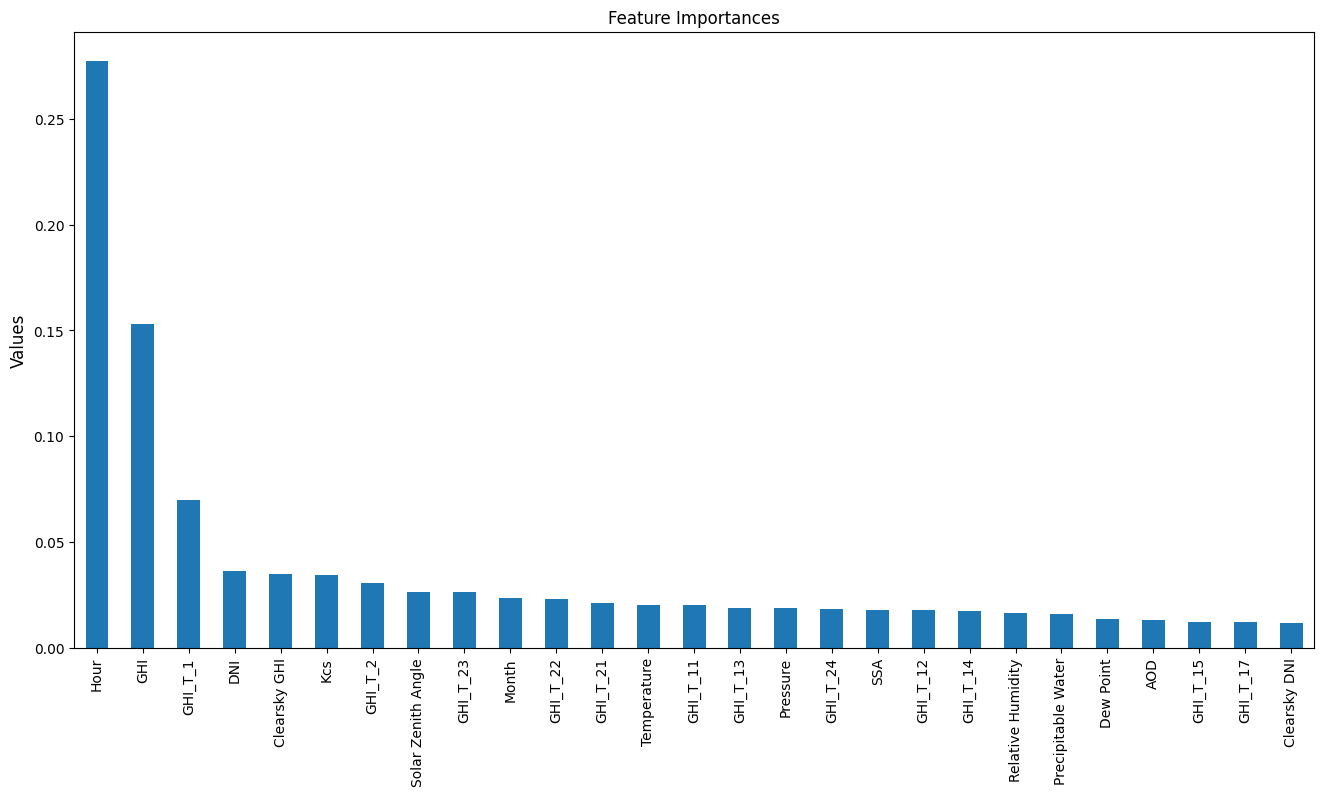

In [30]:
fi = pd.DataFrame(index=X_train_df.columns[feature_indices], data=np.sort(best_model.feature_importances_))
fi.sort_values(by=0, ascending=False)
fi.head()
# Plot feature importance
fi = pd.DataFrame(index=X_train_df.columns[feature_indices], data=np.sort(best_model.feature_importances_))
fi.sort_values(by=0, ascending=False, inplace=True)
ax = fi.plot(kind="bar", title="Feature Importances", figsize=(16, 8))
ax.set_ylabel("Values", fontsize="large")
ax.legend_.remove()

In [31]:
print(fi)

                           0
Hour                0.277454
GHI                 0.152924
GHI_T_1             0.069961
DNI                 0.036122
Clearsky GHI        0.034940
Kcs                 0.034164
GHI_T_2             0.030575
Solar Zenith Angle  0.026450
GHI_T_23            0.026147
Month               0.023324
GHI_T_22            0.023073
GHI_T_21            0.021032
Temperature         0.020245
GHI_T_11            0.020113
GHI_T_13            0.018759
Pressure            0.018563
GHI_T_24            0.018137
SSA                 0.017870
GHI_T_12            0.017793
GHI_T_14            0.017409
Relative Humidity   0.016542
Precipitable Water  0.015934
Dew Point           0.013416
AOD                 0.012917
GHI_T_15            0.012277
GHI_T_17            0.011989
Clearsky DNI        0.011868
